# This notebook uses google-net for transfer learning on the recurrence plots

Install libraries

In [1]:
!pip install tqdm #install tqdm library on colab
!pip install torchmetrics
!pip install seaborn
!pip install scipy
!pip install sns
!pip install PIL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sns: filename=sns-0.1-py3-none-any.whl size=2662 sha256=247ae84a7b0d5f2282e22d647bcd2ece6a797f4d5b1eddd8375c6c5f080665e5
  Stored in directory: /root/.cache/pip/wheels/94/30/68/c7bbc5257894097a14adf5c7d6e7de56127c9936f27afe2416
Successfully built sns
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


Import libraries

In [6]:
import numpy as np 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import normalize

import torch
import torch.nn as nn
from torch import optim 
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset,DataLoader,TensorDataset
import torch.utils.data as data_utils
import torchvision.transforms as transforms  




Use the gpu when possible

In [ ]:
#set torch to GPU
device = torch.device("cpu" if torch.cuda.is_available() else "gpu") 
#set gpu for device
torch.cuda.is_available()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/ML/Recurrence_Plots.zip" -d "/content"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/Recurrence_Plots/Train/rp_b02_250.png  
  inflating: /content/Recurrence_Plots/Train/rp_b02_251.png  
  inflating: /content/Recurrence_Plots/Train/rp_b02_252.png  
  inflating: /content/Recurrence_Plots/Train/rp_b02_253.png  
  inflating: /content/Recurrence_Plots/Train/rp_b02_254.png  
  inflating: /content/Recurrence_Plots/Train/rp_b02_255.png  
  inflating: /content/Recurrence_Plots/Train/rp_b02_256.png  
  inflating: /content/Recurrence_Plots/Train/rp_b02_257.png  
  inflating: /content/Recurrence_Plots/Train/rp_b02_258.png  
  inflating: /content/Recurrence_Plots/Train/rp_b02_259.png  
  inflating: /content/Recurrence_Plots/Train/rp_b02_26.png  
  inflating: /content/Recurrence_Plots/Train/rp_b02_260.png  
  inflating: /content/Recurrence_Plots/Train/rp_b02_261.png  
  inflating: /content/Recurrence_Plots/Train/rp_b02_262.png  
  inflating: /content/Recurrence_Plots/Train/rp_b02_263

Useful constants

In [2]:

path_c = '/content/'

out_directory_train = path_c + 'Recurrence_Plots/Train/'
out_directory_test = path_c + 'Recurrence_Plots/Test/'

# pytorch model

## DataSet class

Our Dataset class, it has a dataframe as attribute to store a mapping annotations and png filenames. We also encode the annotations to binary.

To get one item, one retrieves a random image filename from the dataframe,
retrieves the actual file convert it to RGB, apply transformations and then we return this image with corresponding annotation.

In [4]:
class SpectrogramDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(
            csv_file
        )  # load data input and output from csv file
        self.annotations.columns = ["name", "label"]
        self.annotations["label"] = self.annotations["label"].apply(
            lambda x: 1 if x == "A" else 0
        )
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)  # return length of csv file

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path).convert("RGB")
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

        


## Hyperparameters


In [ ]:
in_channels = 3
num_classes = 2
learning_rate = 0.0001
batch_size = 32
num_epochs = 4

## Create the loaders


Note that google net requires a set of transformations to run.

We create the loaders from two spectrograms datasets, one for training and one for testing

In [7]:
google_net_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

train_set = SpectrogramDataset(csv_file = out_directory_train + 'rp_train_labels.csv', root_dir = out_directory_train, transform = google_net_transform)
test_set = SpectrogramDataset(csv_file = out_directory_test + 'rp_test_labels.csv', root_dir = out_directory_test,transform = google_net_transform)
 
train_loader = DataLoader(dataset= train_set, batch_size = batch_size, shuffle =True)
test_loader = DataLoader(dataset= test_set, batch_size = batch_size, shuffle =True)

## Load the google-net model

We need change the number of classes for prediction, therefore change the shape of the  final layer (model.fc) of the model with the out_features parameter

In [ ]:
model = torchvision.models.googlenet(pretrained = True)
model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=num_classes, bias=True)

# **Train model**

Loss and optimizer


In [ ]:

# Loss and optimizer
criterion =  nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

## Train Network and calculate average loss

In [ ]:
losses = []
accur = []
losses_test = []
accur_test = []
for epoch in range(num_epochs):
  i = 0 
  running_loss =0.0
  for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
    data = data.to(device=device)
    targets = targets.to(device=device)
    data = data.float() 
    scores = model(data)
    loss = criterion(scores, targets)
    optimizer.zero_grad()
    loss.backward()

    # gradient descent or adam step
    optimizer.step()
    running_loss += loss.item()
    i+=1
    if i % 10 == 9:    # print every 4 mini-batches
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
        running_loss = 0.0


  2%|▏         | 9/428 [00:54<40:27,  5.79s/it]

[1,    10] loss: 0.617


  4%|▍         | 19/428 [01:50<38:36,  5.66s/it]

[1,    20] loss: 0.655


  7%|▋         | 29/428 [02:48<38:49,  5.84s/it]

[1,    30] loss: 0.603


  9%|▉         | 39/428 [03:44<36:27,  5.62s/it]

[1,    40] loss: 0.565


 11%|█▏        | 49/428 [04:40<35:36,  5.64s/it]

[1,    50] loss: 0.546


 14%|█▍        | 59/428 [05:38<35:10,  5.72s/it]

[1,    60] loss: 0.542


 16%|█▌        | 69/428 [06:35<33:46,  5.65s/it]

[1,    70] loss: 0.577


 18%|█▊        | 79/428 [07:32<34:34,  5.95s/it]

[1,    80] loss: 0.467


 21%|██        | 89/428 [08:28<31:38,  5.60s/it]

[1,    90] loss: 0.491


 23%|██▎       | 99/428 [09:24<30:35,  5.58s/it]

[1,   100] loss: 0.553


 25%|██▌       | 109/428 [10:21<30:16,  5.69s/it]

[1,   110] loss: 0.526


 28%|██▊       | 119/428 [11:17<28:46,  5.59s/it]

[1,   120] loss: 0.492


 30%|███       | 129/428 [12:13<27:57,  5.61s/it]

[1,   130] loss: 0.480


 32%|███▏      | 139/428 [13:10<27:20,  5.68s/it]

[1,   140] loss: 0.458


 35%|███▍      | 149/428 [14:07<26:25,  5.68s/it]

[1,   150] loss: 0.519


 37%|███▋      | 159/428 [15:08<27:39,  6.17s/it]

[1,   160] loss: 0.469


 39%|███▉      | 169/428 [16:06<24:40,  5.72s/it]

[1,   170] loss: 0.466


 42%|████▏     | 179/428 [17:03<23:38,  5.70s/it]

[1,   180] loss: 0.508


 44%|████▍     | 189/428 [18:01<22:48,  5.72s/it]

[1,   190] loss: 0.543


 46%|████▋     | 199/428 [18:59<22:12,  5.82s/it]

[1,   200] loss: 0.470


 49%|████▉     | 209/428 [19:58<22:05,  6.05s/it]

[1,   210] loss: 0.454


 51%|█████     | 219/428 [20:56<19:59,  5.74s/it]

[1,   220] loss: 0.425


 54%|█████▎    | 229/428 [21:53<18:57,  5.72s/it]

[1,   230] loss: 0.500


 56%|█████▌    | 239/428 [22:51<18:17,  5.81s/it]

[1,   240] loss: 0.430


 58%|█████▊    | 249/428 [23:49<17:08,  5.75s/it]

[1,   250] loss: 0.430


 61%|██████    | 259/428 [24:46<16:10,  5.75s/it]

[1,   260] loss: 0.461


 63%|██████▎   | 269/428 [25:45<15:20,  5.79s/it]

[1,   270] loss: 0.447


 65%|██████▌   | 279/428 [26:42<14:14,  5.74s/it]

[1,   280] loss: 0.406


 68%|██████▊   | 289/428 [27:41<13:39,  5.90s/it]

[1,   290] loss: 0.446


 70%|██████▉   | 299/428 [28:38<12:21,  5.75s/it]

[1,   300] loss: 0.436


 72%|███████▏  | 309/428 [29:36<11:23,  5.75s/it]

[1,   310] loss: 0.488


 75%|███████▍  | 319/428 [30:34<10:26,  5.74s/it]

[1,   320] loss: 0.462


 77%|███████▋  | 329/428 [31:32<09:30,  5.77s/it]

[1,   330] loss: 0.480


 79%|███████▉  | 339/428 [32:30<08:49,  5.95s/it]

[1,   340] loss: 0.463


 82%|████████▏ | 349/428 [33:28<07:34,  5.75s/it]

[1,   350] loss: 0.469


 84%|████████▍ | 359/428 [34:25<06:35,  5.74s/it]

[1,   360] loss: 0.424


 86%|████████▌ | 369/428 [35:24<05:44,  5.84s/it]

[1,   370] loss: 0.455


 89%|████████▊ | 379/428 [36:23<04:46,  5.85s/it]

[1,   380] loss: 0.485


 91%|█████████ | 389/428 [37:22<03:56,  6.07s/it]

[1,   390] loss: 0.472


 93%|█████████▎| 399/428 [38:20<02:48,  5.81s/it]

[1,   400] loss: 0.451


 96%|█████████▌| 409/428 [39:19<01:52,  5.90s/it]

[1,   410] loss: 0.469


 98%|█████████▊| 419/428 [40:17<00:52,  5.79s/it]

[1,   420] loss: 0.408


  2%|▏         | 9/428 [00:53<40:43,  5.83s/it]

[2,    10] loss: 0.351


  4%|▍         | 19/428 [01:51<39:29,  5.79s/it]

[2,    20] loss: 0.335


  7%|▋         | 29/428 [02:50<39:43,  5.97s/it]

[2,    30] loss: 0.405


  9%|▉         | 39/428 [03:48<37:33,  5.79s/it]

[2,    40] loss: 0.345


 11%|█▏        | 49/428 [04:46<36:10,  5.73s/it]

[2,    50] loss: 0.364


 14%|█▍        | 59/428 [05:44<35:41,  5.80s/it]

[2,    60] loss: 0.330


 16%|█▌        | 69/428 [06:41<34:11,  5.71s/it]

[2,    70] loss: 0.367


 18%|█▊        | 79/428 [07:40<34:21,  5.91s/it]

[2,    80] loss: 0.374


 21%|██        | 89/428 [08:37<32:04,  5.68s/it]

[2,    90] loss: 0.378


 23%|██▎       | 99/428 [09:33<30:46,  5.61s/it]

[2,   100] loss: 0.358


 25%|██▌       | 109/428 [10:30<30:07,  5.67s/it]

[2,   110] loss: 0.368


 28%|██▊       | 119/428 [11:27<29:16,  5.68s/it]

[2,   120] loss: 0.340


 30%|███       | 129/428 [12:25<29:52,  5.99s/it]

[2,   130] loss: 0.363


 32%|███▏      | 139/428 [13:21<27:15,  5.66s/it]

[2,   140] loss: 0.330


 35%|███▍      | 149/428 [14:18<26:15,  5.65s/it]

[2,   150] loss: 0.358


 37%|███▋      | 159/428 [15:15<25:30,  5.69s/it]

[2,   160] loss: 0.342


 39%|███▉      | 169/428 [16:12<24:27,  5.67s/it]

[2,   170] loss: 0.415


 42%|████▏     | 179/428 [17:10<23:52,  5.75s/it]

[2,   180] loss: 0.337


 44%|████▍     | 189/428 [18:07<22:33,  5.66s/it]

[2,   190] loss: 0.400


 46%|████▋     | 199/428 [19:04<21:31,  5.64s/it]

[2,   200] loss: 0.321


 49%|████▉     | 209/428 [20:02<21:08,  5.79s/it]

[2,   210] loss: 0.357


 51%|█████     | 219/428 [20:59<19:52,  5.71s/it]

[2,   220] loss: 0.433


 54%|█████▎    | 229/428 [21:56<18:51,  5.69s/it]

[2,   230] loss: 0.378


 56%|█████▌    | 239/428 [22:54<17:50,  5.66s/it]

[2,   240] loss: 0.402


 58%|█████▊    | 249/428 [23:50<16:48,  5.63s/it]

[2,   250] loss: 0.373


 61%|██████    | 259/428 [24:48<16:25,  5.83s/it]

[2,   260] loss: 0.320


 63%|██████▎   | 269/428 [25:45<14:58,  5.65s/it]

[2,   270] loss: 0.420


 65%|██████▌   | 279/428 [26:41<13:56,  5.61s/it]

[2,   280] loss: 0.297


 68%|██████▊   | 289/428 [27:38<13:08,  5.67s/it]

[2,   290] loss: 0.381


 70%|██████▉   | 299/428 [28:34<12:00,  5.59s/it]

[2,   300] loss: 0.308


 72%|███████▏  | 309/428 [29:31<11:35,  5.84s/it]

[2,   310] loss: 0.308


 75%|███████▍  | 319/428 [30:27<10:05,  5.56s/it]

[2,   320] loss: 0.416


 77%|███████▋  | 329/428 [31:22<09:14,  5.60s/it]

[2,   330] loss: 0.371


 79%|███████▉  | 339/428 [32:19<08:31,  5.74s/it]

[2,   340] loss: 0.411


 82%|████████▏ | 349/428 [33:16<07:25,  5.64s/it]

[2,   350] loss: 0.374


 84%|████████▍ | 359/428 [34:12<06:21,  5.53s/it]

[2,   360] loss: 0.333


 86%|████████▌ | 369/428 [35:08<05:27,  5.55s/it]

[2,   370] loss: 0.332


 89%|████████▊ | 379/428 [36:04<04:30,  5.52s/it]

[2,   380] loss: 0.440


 91%|█████████ | 389/428 [37:00<03:44,  5.76s/it]

[2,   390] loss: 0.324


 93%|█████████▎| 399/428 [37:56<02:41,  5.55s/it]

[2,   400] loss: 0.345


 96%|█████████▌| 409/428 [38:52<01:46,  5.58s/it]

[2,   410] loss: 0.357


 98%|█████████▊| 419/428 [39:48<00:50,  5.67s/it]

[2,   420] loss: 0.381


  2%|▏         | 9/428 [00:50<39:10,  5.61s/it]

[3,    10] loss: 0.255


  4%|▍         | 19/428 [01:47<38:38,  5.67s/it]

[3,    20] loss: 0.235


  7%|▋         | 29/428 [02:43<36:59,  5.56s/it]

[3,    30] loss: 0.264


  9%|▉         | 39/428 [03:39<36:12,  5.59s/it]

[3,    40] loss: 0.276


 11%|█▏        | 49/428 [04:36<35:35,  5.63s/it]

[3,    50] loss: 0.242


 14%|█▍        | 59/428 [05:31<34:06,  5.55s/it]

[3,    60] loss: 0.275


 16%|█▌        | 69/428 [06:28<34:17,  5.73s/it]

[3,    70] loss: 0.310


 18%|█▊        | 79/428 [07:25<32:28,  5.58s/it]

[3,    80] loss: 0.236


 21%|██        | 89/428 [08:20<31:15,  5.53s/it]

[3,    90] loss: 0.265


 23%|██▎       | 99/428 [09:17<31:34,  5.76s/it]

[3,   100] loss: 0.229


 25%|██▌       | 109/428 [10:13<29:49,  5.61s/it]

[3,   110] loss: 0.239


 28%|██▊       | 119/428 [11:09<28:34,  5.55s/it]

[3,   120] loss: 0.261


 30%|███       | 129/428 [12:06<28:15,  5.67s/it]

[3,   130] loss: 0.220


 32%|███▏      | 139/428 [13:02<26:53,  5.58s/it]

[3,   140] loss: 0.241


 35%|███▍      | 149/428 [13:57<26:09,  5.62s/it]

[3,   150] loss: 0.220


 37%|███▋      | 159/428 [14:56<25:37,  5.71s/it]

[3,   160] loss: 0.281


 39%|███▉      | 169/428 [15:52<24:21,  5.64s/it]

[3,   170] loss: 0.302


 42%|████▏     | 179/428 [16:49<23:37,  5.69s/it]

[3,   180] loss: 0.311


 44%|████▍     | 189/428 [17:46<22:31,  5.66s/it]

[3,   190] loss: 0.273


 46%|████▋     | 199/428 [18:42<21:37,  5.67s/it]

[3,   200] loss: 0.239


 49%|████▉     | 209/428 [19:40<21:16,  5.83s/it]

[3,   210] loss: 0.247


 51%|█████     | 219/428 [20:36<19:44,  5.67s/it]

[3,   220] loss: 0.316


 54%|█████▎    | 229/428 [21:33<18:43,  5.65s/it]

[3,   230] loss: 0.319


 56%|█████▌    | 239/428 [22:31<18:03,  5.74s/it]

[3,   240] loss: 0.279


 58%|█████▊    | 249/428 [23:28<16:56,  5.68s/it]

[3,   250] loss: 0.305


 61%|██████    | 259/428 [24:24<15:38,  5.55s/it]

[3,   260] loss: 0.264


 63%|██████▎   | 269/428 [25:21<14:43,  5.56s/it]

[3,   270] loss: 0.297


 65%|██████▌   | 279/428 [26:17<13:54,  5.60s/it]

[3,   280] loss: 0.279


 68%|██████▊   | 289/428 [27:13<13:05,  5.65s/it]

[3,   290] loss: 0.227


 70%|██████▉   | 299/428 [28:11<12:11,  5.67s/it]

[3,   300] loss: 0.278


 72%|███████▏  | 309/428 [29:08<11:17,  5.69s/it]

[3,   310] loss: 0.287


 75%|███████▍  | 319/428 [30:06<10:48,  5.95s/it]

[3,   320] loss: 0.307


 77%|███████▋  | 329/428 [31:03<09:24,  5.70s/it]

[3,   330] loss: 0.319


 79%|███████▉  | 339/428 [31:59<08:26,  5.69s/it]

[3,   340] loss: 0.254


 82%|████████▏ | 349/428 [32:57<07:34,  5.75s/it]

[3,   350] loss: 0.222


 84%|████████▍ | 359/428 [33:53<06:27,  5.62s/it]

[3,   360] loss: 0.351


 86%|████████▌ | 369/428 [34:49<05:29,  5.59s/it]

[3,   370] loss: 0.341


 89%|████████▊ | 379/428 [35:47<04:36,  5.64s/it]

[3,   380] loss: 0.291


 91%|█████████ | 389/428 [36:43<03:39,  5.64s/it]

[3,   390] loss: 0.305


 93%|█████████▎| 399/428 [37:39<02:41,  5.58s/it]

[3,   400] loss: 0.255


 96%|█████████▌| 409/428 [38:36<01:45,  5.54s/it]

[3,   410] loss: 0.265


 98%|█████████▊| 419/428 [39:30<00:49,  5.47s/it]

[3,   420] loss: 0.280


  2%|▏         | 9/428 [00:50<38:48,  5.56s/it]

[4,    10] loss: 0.148


  4%|▍         | 19/428 [01:45<37:33,  5.51s/it]

[4,    20] loss: 0.161


  7%|▋         | 29/428 [02:41<36:44,  5.53s/it]

[4,    30] loss: 0.197


  9%|▉         | 39/428 [03:37<35:56,  5.54s/it]

[4,    40] loss: 0.158


 11%|█▏        | 49/428 [04:32<34:52,  5.52s/it]

[4,    50] loss: 0.124


 14%|█▍        | 59/428 [05:28<35:14,  5.73s/it]

[4,    60] loss: 0.174


 16%|█▌        | 69/428 [06:24<33:16,  5.56s/it]

[4,    70] loss: 0.193


 18%|█▊        | 79/428 [07:20<32:14,  5.54s/it]

[4,    80] loss: 0.151


 21%|██        | 89/428 [08:16<32:06,  5.68s/it]

[4,    90] loss: 0.148


 23%|██▎       | 99/428 [09:11<30:11,  5.51s/it]

[4,   100] loss: 0.157


 25%|██▌       | 109/428 [10:06<29:15,  5.50s/it]

[4,   110] loss: 0.154


 28%|██▊       | 119/428 [11:03<29:39,  5.76s/it]

[4,   120] loss: 0.167


 30%|███       | 129/428 [11:57<27:10,  5.45s/it]

[4,   130] loss: 0.151


 32%|███▏      | 139/428 [12:52<26:24,  5.48s/it]

[4,   140] loss: 0.130


 35%|███▍      | 149/428 [13:48<26:10,  5.63s/it]

[4,   150] loss: 0.156


 37%|███▋      | 159/428 [14:43<24:49,  5.54s/it]

[4,   160] loss: 0.197


 39%|███▉      | 169/428 [15:38<23:43,  5.50s/it]

[4,   170] loss: 0.163


 42%|████▏     | 179/428 [16:34<23:15,  5.60s/it]

[4,   180] loss: 0.153


 44%|████▍     | 189/428 [17:29<21:40,  5.44s/it]

[4,   190] loss: 0.165


 46%|████▋     | 199/428 [18:23<20:54,  5.48s/it]

[4,   200] loss: 0.163


 49%|████▉     | 209/428 [19:20<20:31,  5.63s/it]

[4,   210] loss: 0.186


 51%|█████     | 219/428 [20:15<19:10,  5.51s/it]

[4,   220] loss: 0.200


 54%|█████▎    | 229/428 [21:11<18:43,  5.65s/it]

[4,   230] loss: 0.192


 56%|█████▌    | 239/428 [22:08<17:37,  5.60s/it]

[4,   240] loss: 0.141


 58%|█████▊    | 249/428 [23:05<17:05,  5.73s/it]

[4,   250] loss: 0.133


 61%|██████    | 259/428 [24:02<15:49,  5.62s/it]

[4,   260] loss: 0.153


 63%|██████▎   | 269/428 [24:58<14:41,  5.54s/it]

[4,   270] loss: 0.150


 65%|██████▌   | 279/428 [25:54<13:52,  5.59s/it]

[4,   280] loss: 0.195


 68%|██████▊   | 289/428 [26:49<12:50,  5.54s/it]

[4,   290] loss: 0.178


 70%|██████▉   | 299/428 [27:47<12:08,  5.65s/it]

[4,   300] loss: 0.171


 72%|███████▏  | 309/428 [28:43<11:07,  5.61s/it]

[4,   310] loss: 0.178


 75%|███████▍  | 319/428 [29:39<10:02,  5.53s/it]

[4,   320] loss: 0.245


 77%|███████▋  | 329/428 [30:35<09:06,  5.52s/it]

[4,   330] loss: 0.181


 79%|███████▉  | 339/428 [31:31<08:13,  5.54s/it]

[4,   340] loss: 0.207


 82%|████████▏ | 349/428 [32:26<07:16,  5.52s/it]

[4,   350] loss: 0.181


 84%|████████▍ | 359/428 [33:22<06:21,  5.53s/it]

[4,   360] loss: 0.186


 86%|████████▌ | 369/428 [34:17<05:24,  5.49s/it]

[4,   370] loss: 0.238


 89%|████████▊ | 379/428 [35:12<04:28,  5.48s/it]

[4,   380] loss: 0.202


 91%|█████████ | 389/428 [36:08<03:35,  5.53s/it]

[4,   390] loss: 0.227


 93%|█████████▎| 399/428 [37:04<02:41,  5.56s/it]

[4,   400] loss: 0.250


 96%|█████████▌| 409/428 [37:59<01:45,  5.53s/it]

[4,   410] loss: 0.152


 98%|█████████▊| 419/428 [38:55<00:49,  5.53s/it]

[4,   420] loss: 0.210


100%|██████████| 428/428 [39:43<00:00,  5.57s/it]


'\n  losses.append(loss.detach().numpy())\n  accur.append(acc)\n  losses_test.append(loss_test.detach().numpy())\n  accur_test.append(acc_test)\n  print("\n epoch {}\tloss_train : {}\t accuracy_train : {}%".format(epoch,loss,acc*100))\n  print("epoch {}\tloss_test : {}\t accuracy_test : {}%\n".format(epoch,loss_test,acc_test*100))\n  \n'

# Testing

This function returns the true_positives, false_positives, true_negatives, false_negatives

In [7]:
def confusion(prediction, truth):
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """
    confusion_vector = prediction / truth
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)

    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

This function iterates through the test_loader, and calculates the different useful metrics: sensitivity, specificity, F1, Youden's index and accuracy. It also generates a confusion matrix using seaborn.

Checking accuracy on test data
Got 68.87277122997885 
Sensitivity: 0.3358843537414966
Specificity: 0.8832630098452883
F1: 0.434065934065934
Youden's index: 0.21914736358678488


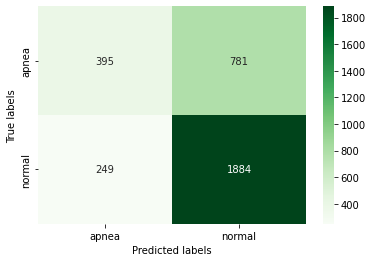

In [ ]:
def check_accuracy(loader, model):
    model.eval()
    accuracy = 0.0
    total = 0.0
    if loader == "train":
        print("Checking accuracy on train data")
        with torch.no_grad():
            for data in train_loader:
                segments, labels = data
                # run the model on the test set to predict labels
                segments = segments.float()
                outputs = model(segments)

                # the label with the highest energy will be our prediction
                _, predicted = torch.max(outputs.data, 1)

                TP = (predicted == labels == 1).sum()
                total += labels.size(0)
                accuracy += (predicted == labels).sum().item()

                # compute the accuracy over all test segments
            accuracy = 100 * accuracy / total
            print(f"Got {accuracy} ")

    else:
        print("Checking accuracy on test data")
        with torch.no_grad():
            true_positives, false_positives, true_negatives, false_negatives = (
                0,
                0,
                0,
                0,
            )
            predicted_tot = torch.zeros(0)
            labels_tot = torch.zeros(0)

            for data in test_loader:
                segments, labels = data
                # run the model on the test set to predict labels
                segments = segments.float()
                outputs = model(segments)

                predicted_tot = torch.cat([predicted_tot, outputs], dim=0)
                labels_tot = torch.cat([labels_tot, labels], dim=0)
                # the label with the highest energy will be our prediction
                _, predicted = torch.max(outputs.data, 1)

                tp, fp, tn, fn = confusion(predicted, labels)

                true_positives += tp
                false_positives += fp
                true_negatives += tn
                false_negatives += fn

                total += labels.size(0)
                accuracy += (predicted == labels).sum().item()

            # compute the accuracy over all test segment
            accuracy = 100 * accuracy / total
            print(f"Got {accuracy} ")

            sensitivity = true_positives / (true_positives + false_negatives)
            specificity = true_negatives / (true_negatives + false_positives)
            precision = true_positives / (true_positives + false_positives)
            recall = true_positives / (true_positives + false_negatives)
            F1 = (2 * precision * recall) / (precision + recall)

            print(f"Sensitivity: {sensitivity}")
            print(f"Specificity: {specificity}")
            print(f"F1: {F1}")
            print(f"Youden's index: {sensitivity + specificity - 1 }")

            # Plot confusion matrix
            cm = [[true_positives, false_negatives], [false_positives, true_negatives]]

            ax = plt.subplot()
            sns.heatmap(cm, annot=True, fmt="g", cmap="Greens", ax=ax)
            # annot=True to annotate cells, ftm='g' to disable scientific notation

            # labels, title and ticks
            ax.set_xlabel("Predicted labels")
            ax.set_ylabel("True labels")
            # ax.set_title('Confusion Matrix');
            ax.xaxis.set_ticklabels(["apnea", "normal"])
            ax.yaxis.set_ticklabels(["apnea", "normal"])


# check_accuracy("train", model)
check_accuracy("test", model)